In [1]:
import sys
sys.path.append('../python')
import torch
from models import FashionCNN

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import pickle
import os
import numpy as np

In [3]:
# Load metrics
data_dir = os.path.join(os.getcwd(), '../data')
metrics_file = os.path.join(data_dir, 'fashion_metrics.pkl')


with open(metrics_file, 'rb') as f:
    params_epochs = pickle.load(f)

In [4]:
# Plots params
sns.set_style('whitegrid')
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'

plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
text_and_line_color = '#808080'
plt.rcParams['text.color'] = text_and_line_color
plt.rcParams['axes.labelcolor'] = text_and_line_color
plt.rcParams['xtick.color'] = text_and_line_color
plt.rcParams['ytick.color'] = text_and_line_color
plt.rcParams['axes.edgecolor'] = text_and_line_color

figs_dir = os.path.join(data_dir, '../figs')

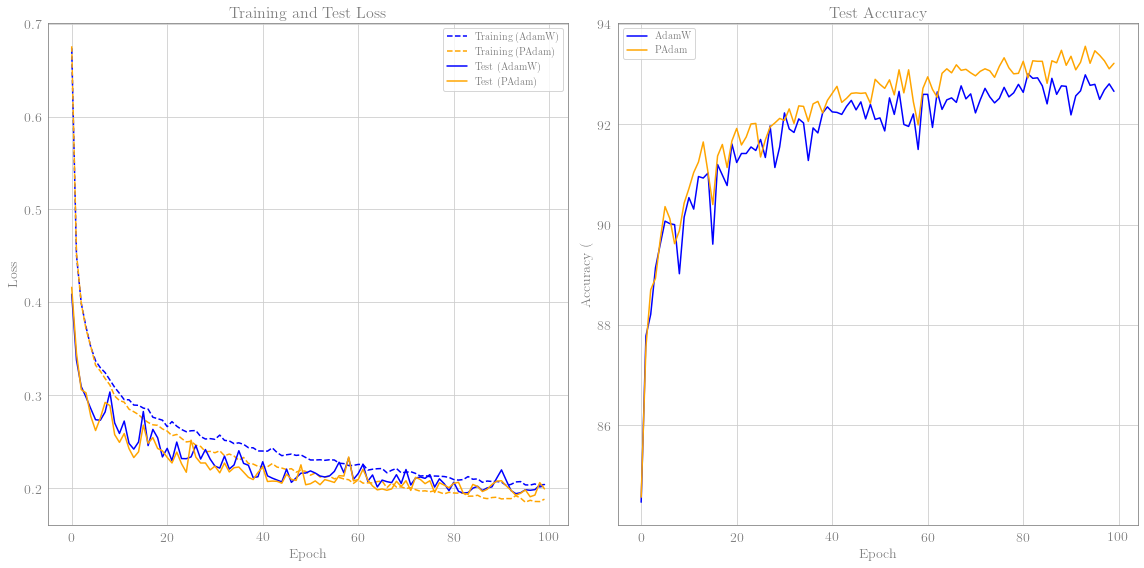

In [5]:
# Define the side-by-side subplot structure with a shared y-axis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Plot training and test loss
ax1.plot(params_epochs['train_1'], label='Training (AdamW)', color='blue', ls='--')
ax1.plot(params_epochs['train_2'], label='Training (PAdam)', color='orange', ls='--')
ax1.plot(params_epochs['test_1'], label='Test (AdamW)', color='blue')
ax1.plot(params_epochs['test_2'], label='Test (PAdam)', color='orange')
ax1.set_xlabel('Epoch', fontsize=14)
ax1.set_ylabel('Loss', fontsize=14)
ax1.set_title('Training and Test Loss', fontsize=16)
ax1.legend()

# Plot accuracy
ax2.plot(params_epochs['accuracy_1'], label='AdamW', color='blue')
ax2.plot(params_epochs['accuracy_2'], label='PAdam', color='orange')
ax2.set_xlabel('Epoch', fontsize=14)
ax2.set_ylabel('Accuracy (%)', fontsize=14)
ax2.set_title('Test Accuracy', fontsize=16)
ax2.legend()

# Adjust layout
plt.tight_layout()

# Save the full figure
if not os.path.exists(figs_dir):
        os.makedirs(figs_dir)
plt.savefig(os.path.join(figs_dir, 'fashion_padam_curves.png'), dpi=300, bbox_inches='tight', transparent=True)

# Show the plot
plt.show()

In [9]:
params_epochs['small_weights_2']
1

1

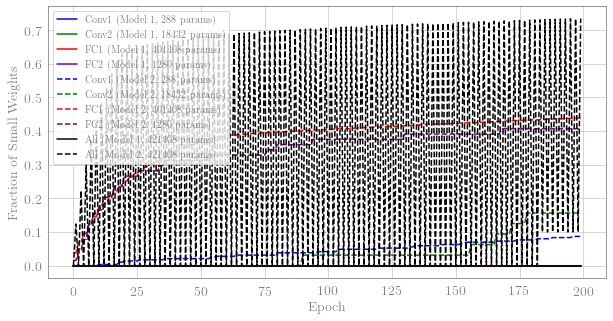

In [6]:
model = FashionCNN()
parameters_per_layer = [p.numel() for p in model.parameters() if p.requires_grad]


# Define the labels and colors for the layers you want to plot
layer_labels = ['Conv1', 'Conv2', 'FC1', 'FC2']
layer_colors = ['blue', 'green', 'red', 'purple']

# Extract the number of parameters for weights only
num_params_weights = parameters_per_layer[::2]  # Taking every second element

# Plot for the fraction of small weights per layer for Model 1
plt.figure(figsize=(10, 5))

for i, (label, color) in enumerate(zip(layer_labels, layer_colors)):
    # Extract fractions for the i-th weight layer across all epochs for Model 1
    fractions = [epoch_fractions[i] for epoch_fractions in params_epochs['small_weights_1']]
    plt.plot(fractions, label=f'{label} (Model 1, {num_params_weights[i]} params)', color=color, ls='-')

# Plot for the fraction of small weights per layer for Model 2
for i, (label, color) in enumerate(zip(layer_labels, layer_colors)):
    # Extract fractions for the i-th weight layer across all epochs for Model 2
    fractions = [epoch_fractions[i] for epoch_fractions in params_epochs['small_weights_2']]
    plt.plot(fractions, label=f'{label} (Model 2, {num_params_weights[i]} params)', color=color, ls='--')

# Plot the overall weighted fraction of small weights for comparison for both models
weighted_fractions_1 = [frac[-1] for frac in params_epochs['small_weights_1']]
weighted_fractions_2 = [frac[-1] for frac in params_epochs['small_weights_2']]
plt.plot(weighted_fractions_1, label=f'All (Model 1, {np.sum(num_params_weights)} params)', color='black', ls='-')
plt.plot(weighted_fractions_2, label=f'All (Model 2, {np.sum(num_params_weights)} params)', color='black', ls='--')

# Adding labels and title
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Fraction of Small Weights', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()


In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../python')

from functions import *
from models import *
from Optimizers import *

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataloader as dataloader
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR

from torch.utils.data import TensorDataset
from torch.autograd import Variable
from torchvision import transforms
from torchvision.datasets import FashionMNIST



from tqdm import *
import copy



import time

import pickle





In [2]:
# List all available GPUs
print(torch.cuda.device_count())

# Get the name of the GPUs
for i in range(torch.cuda.device_count()):
    print(torch.cuda.get_device_name(i))


# CUDA?
cuda = torch.cuda.is_available()
device = torch.device("cuda:3" if cuda else "cpu") # for GPU 0


# For reproducibility
SEED = 2349
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

4
NVIDIA A40
NVIDIA A40
NVIDIA A40
NVIDIA A40


In [4]:
# Load the mean and std_dev values
with open('../data/fashion_mnist_stats.pkl', 'rb') as f:
    stats = pickle.load(f)
    train_mean = stats['train_mean']
    train_std = stats['train_std']
    test_mean = stats['test_mean']
    test_std = stats['test_std']

# Define transforms using calculated mean and std
train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
#     transforms.RandomHorizontalFlip(),

    transforms.ToTensor(),
    transforms.Normalize(mean=(train_mean,), std=(train_std,))
#     transforms.RandomErasing(p=0.2, scale=(0.02, 0.33), ratio=(0.3, 3.3), value="random", inplace=False)
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(test_mean,), std=(test_std,))
])

# Create new datasets using the normalization calculated
train = FashionMNIST('../data', train=True, download=True, transform=train_transform)
test = FashionMNIST('../data', train=False, download=True, transform=test_transform)


# Create DataLoader
dataloader_args = dict(shuffle=True, batch_size=256,num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)
train_loader = dataloader.DataLoader(train, **dataloader_args)
test_loader = dataloader.DataLoader(test, **dataloader_args)

### Load models

In [5]:
model_fc = Model()
params_fc = sum(p.numel() for p in model_fc.parameters())
print(f'Total number of parameters in FC model: {params_fc}')

model_cnn = SimpleCNN()
params_cnn = sum(p.numel() for p in model_cnn.parameters())
print(f'Total number of parameters in CNN model: {params_cnn}')

model_cnn = SimplestCNN()
params_cnn = sum(p.numel() for p in model_cnn.parameters())
print(f'Total number of parameters in CNN_smal model: {params_cnn}')

model_f = FashionCNN()
n_params_fashion = sum(p.numel() for p in model_f.parameters())
print(f'Total number of parameters in fashion model: {n_params_fashion}')

Total number of parameters in FC model: 795010
Total number of parameters in CNN model: 941526
Total number of parameters in CNN_smal model: 23466
Total number of parameters in fashion model: 421642


In [39]:
Model_1 = FashionCNN()
Model_2 = copy.deepcopy(Model_1)

# Move models to the appropriate device
Model_1.to(device)
Model_2.to(device)

# Set parameters
LR_1 = 3e-3
WD = 1e-1

LR_2 = 3e-3
lambda_p = 3e-3
p_norm = 0.8

EPOCHS = 400
small_weight_threshold = 1e-12  # Define the threshold for small weights

optimizer_1 = optim.AdamW(Model_1.parameters(), lr=LR1, weight_decay=WD)
# optimizer_2 = AdamSqueeze(Model_2.parameters(), lr=LR, lambda_=3e-3, lp_order=0.8, type='soft', s_initial=1)
optimizer_2 = PAdam(Model_2.parameters(), lr=LR2, lambda_p=lambda_p ,p_norm=p_norm)

# Schedulers
rate = 10**(-0.6 / EPOCHS)
scheduler_1 = ExponentialLR(optimizer_1, rate)
scheduler_2 = ExponentialLR(optimizer_2, rate)

# Initialize dictionaries of things we want to keep
params_epochs = {
    'train_1': [], 'train_2': [],
    'test_1': [], 'test_2': [],
    'accuracy_1': [], 'accuracy_2': [],
    'small_weights_1': [], 'small_weights_2': []
}

parameters_per_layer=np.array([p.nelement() for p in Model_2.parameters() if p.requires_grad])
parameters_per_layer_weight=parameters_per_layer/np.sum(parameters_per_layer)


# Function to calculate the fraction of small weights for a given parameter tensor
def fraction_small_weights(param, threshold):
    small_weights = torch.sum(torch.abs(param.data) < threshold).item()
    total_weights = param.nelement()
    return small_weights / total_weights


# Record the start time
start_time = time.time()

# Training loop
for epoch in range(EPOCHS):
    Model_1.train()
    Model_2.train()

    # Variables to store info per epoch
    train_loss_epoch_1 = 0
    train_loss_epoch_2 = 0
#     small_weights_epoch_1 = 0
#     small_weights_epoch_2 = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        optimizer_1.zero_grad()
        optimizer_2.zero_grad()

        y_pred_1 = Model_1(data)
        y_pred_2 = Model_2(data)

        loss_1 = F.cross_entropy(y_pred_1, target)
        loss_2 = F.cross_entropy(y_pred_2, target)
        train_loss_epoch_1 += loss_1.item()
        train_loss_epoch_2 += loss_2.item()

        loss_1.backward()
        optimizer_1.step()
        loss_2.backward()
        optimizer_2.step()

    # After training, calculate the fraction of small weights for each parameter group
    # Variables to store fractions of small weights for each layer
    small_weights_layers_1 = []
    small_weights_layers_2 = []

    # After training, calculate the fraction of small weights for each layer
    for param in Model_1.parameters():
        if param.requires_grad:
            small_weights_layers_1.append(fraction_small_weights(param, small_weight_threshold))
    for param in Model_2.parameters():
        if param.requires_grad:
            small_weights_layers_2.append(fraction_small_weights(param, small_weight_threshold))
    
    # Store the fractions of small weights for each layer
    params_epochs['small_weights_1'].append(small_weights_layers_1)
    params_epochs['small_weights_2'].append(small_weights_layers_2)
    total_frac_model_2=parameters_per_layer_weight @ np.array(small_weights_layers_2)



    # Calculate the average training loss for this epoch and store
    params_epochs['train_1'].append(train_loss_epoch_1 / len(train_loader))
    params_epochs['train_2'].append(train_loss_epoch_2 / len(train_loader))

    # Evaluation phase
    Model_1.eval()
    Model_2.eval()
    test_loss_1 = 0
    correct_1 = 0
    test_loss_2 = 0
    correct_2 = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)

            # Evaluate Model_1
            output_1 = Model_1(data)
            test_loss_1 += F.cross_entropy(output_1, target).item()
            pred_1 = output_1.argmax(dim=1, keepdim=True)
            correct_1 += pred_1.eq(target.view_as(pred_1)).sum().item()

            # Evaluate Model_2
            output_2 = Model_2(data)
            test_loss_2 += F.cross_entropy(output_2, target).item()
            pred_2 = output_2.argmax(dim=1, keepdim=True)
            correct_2 += pred_2.eq(target.view_as(pred_2)).sum().item()

    # Calculate the average test loss and accuracy
    test_loss_1 /= len(test_loader)
    test_loss_2 /= len(test_loader)
    accuracy_1 = 100. * correct_1 / len(test_loader.dataset)
    accuracy_2 = 100. * correct_2 / len(test_loader.dataset)

    # Store the results
    params_epochs['test_1'].append(test_loss_1)
    params_epochs['test_2'].append(test_loss_2)
    params_epochs['accuracy_1'].append(accuracy_1)
    params_epochs['accuracy_2'].append(accuracy_2)

    # Update learning rate
    scheduler_1.step()
    scheduler_2.step()

    # Calculate runtime and expected time
    elapsed_time = time.time() - start_time
    expected_time = elapsed_time * EPOCHS / (epoch + 1)

    # Format the elapsed and expected times as strings
    elapsed_str = time.strftime("%H:%M:%S", time.gmtime(elapsed_time))
    expected_str = time.strftime("%H:%M:%S", time.gmtime(expected_time))

    print(f"\rTrain Epoch: {epoch+1}/{EPOCHS}\tTrain Loss: {params_epochs['train_1'][-1]:.4f} | {params_epochs['train_2'][-1]:.4f}\tTest Loss: {params_epochs['test_1'][-1]:.4f} | {params_epochs['test_2'][-1]:.4f}\tAccuracy: {params_epochs['accuracy_1'][-1]:.2f}% | {params_epochs['accuracy_2'][-1]:.2f}%\tSmall Weights fraction{100*total_frac_model_2:.2f}%\tElapsed Time: {elapsed_str}\tExpected Time: {expected_str}", end='')
print()


Train Epoch: 400/400	Train Loss: 0.1849 | 0.1516	Test Loss: 0.1947 | 0.1957	Accuracy: 92.71% | 93.34%	Small Weights fraction79.67%	Elapsed Time: 00:35:54	Expected Time: 00:35:54


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# Set up some parameters for pretty plots
import matplotlib as mpl
sns.set_style('whitegrid')
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'

plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

# Colors & styles adjustments for better visibility on both backgrounds
text_and_line_color = '#808080'
plt.rcParams['text.color'] = text_and_line_color
plt.rcParams['axes.labelcolor'] = text_and_line_color
plt.rcParams['xtick.color'] = text_and_line_color
plt.rcParams['ytick.color'] = text_and_line_color
plt.rcParams['axes.edgecolor'] = text_and_line_color

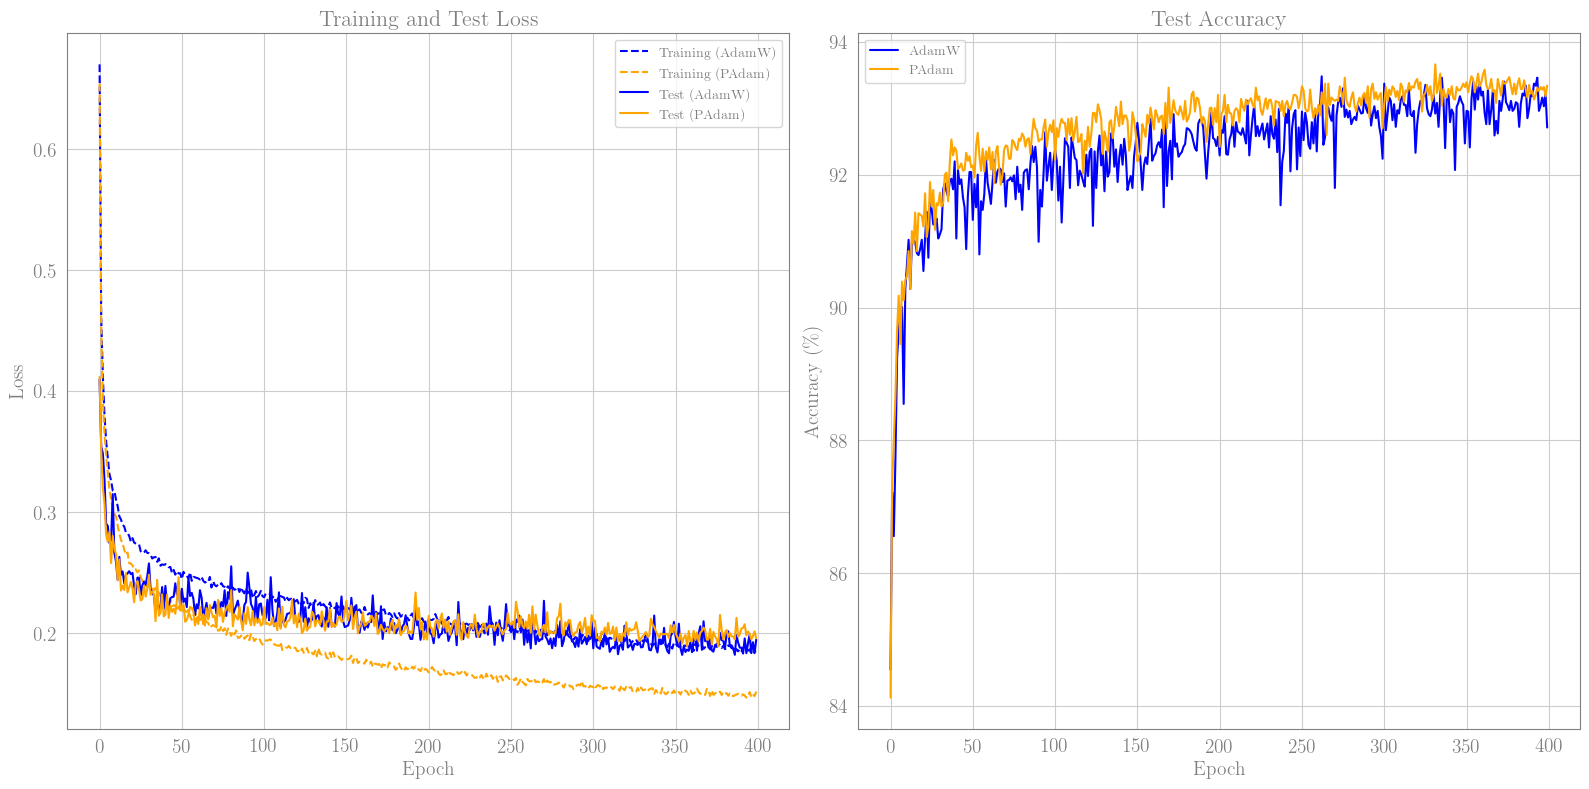

In [81]:
# Define the side-by-side subplot structure with a shared y-axis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Plot training and test loss
ax1.plot(params_epochs['train_1'], label='Training (AdamW)', color='blue', ls='--')
ax1.plot(params_epochs['train_2'], label='Training (PAdam)', color='orange', ls='--')
ax1.plot(params_epochs['test_1'], label='Test      (AdamW)', color='blue')
ax1.plot(params_epochs['test_2'], label='Test      (PAdam)', color='orange')
ax1.set_xlabel('Epoch', fontsize=14)
ax1.set_ylabel('Loss', fontsize=14)
ax1.set_title('Training and Test Loss', fontsize=16)
ax1.legend()



# Plot accuracy
ax2.plot(params_epochs['accuracy_1'], label='AdamW', color='blue')
ax2.plot(params_epochs['accuracy_2'], label='PAdam', color='orange')
ax2.set_xlabel('Epoch', fontsize=14)
ax2.set_ylabel('Accuracy (\%)', fontsize=14)
ax2.set_title('Test Accuracy', fontsize=16)
ax2.legend()


# Adjust layout
plt.tight_layout()

# Save the full figure
plt.savefig('../figs/fashion_padam_curves', dpi=300, bbox_inches='tight', transparent=True)

# Show the plot
plt.show()

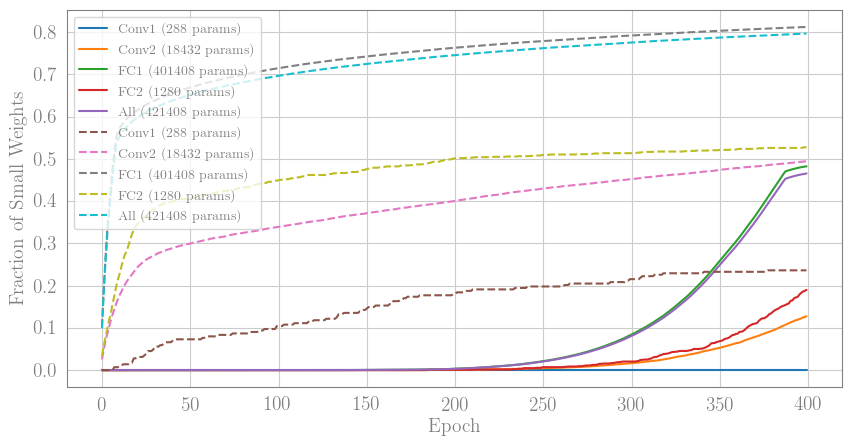

In [51]:

# Define the labels and colors for the layers you want to plot
layer_labels = ['Conv1', 'Conv2', 'FC1', 'FC2']
layer_colors = ['blue', 'green', 'red', 'purple']

# Assume parameters_per_layer contains the number of parameters for each weight/bias in order
# Extract the number of parameters for weights only
num_params_weights = parameters_per_layer[::2]  # Taking every second element

# Plot for the fraction of small weights per layer
plt.figure(figsize=(10, 5))
for i, (label, color) in enumerate(zip(layer_labels, layer_colors)):
    # Extract fractions for the i-th weight layer across all epochs
    fractions = [epoch_fractions[i*2] for epoch_fractions in params_epochs['small_weights_1']]
    plt.plot(fractions, label=f'{label} ({num_params_weights[i]} params)')

# Plot the overall weighted fraction of small weights for comparison
weighted_fractions = np.array(params_epochs['small_weights_1'])[:, ::2] @ (parameters_per_layer_weight[::2])
plt.plot(weighted_fractions, label=f'All ({np.sum(num_params_weights)} params)')


for i, (label, color) in enumerate(zip(layer_labels, layer_colors)):
    # Extract fractions for the i-th weight layer across all epochs
    fractions = [epoch_fractions[i*2] for epoch_fractions in params_epochs['small_weights_2']]
    plt.plot(fractions, label=f'{label} ({num_params_weights[i]} params)',ls='--')

# Plot the overall weighted fraction of small weights for comparison
weighted_fractions = np.array(params_epochs['small_weights_2'])[:, ::2] @ (parameters_per_layer_weight[::2])
plt.plot(weighted_fractions, label=f'All ({np.sum(num_params_weights)} params)',ls='--')

# Adding labels and title
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Fraction of Small Weights', fontsize=14)
# plt.title('Fraction of Small Weights', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()


In [48]:
np.array(params_epochs['small_weights_1'])[-1, ::2] @ (parameters_per_layer_weight[::2])

0.4652928313593048

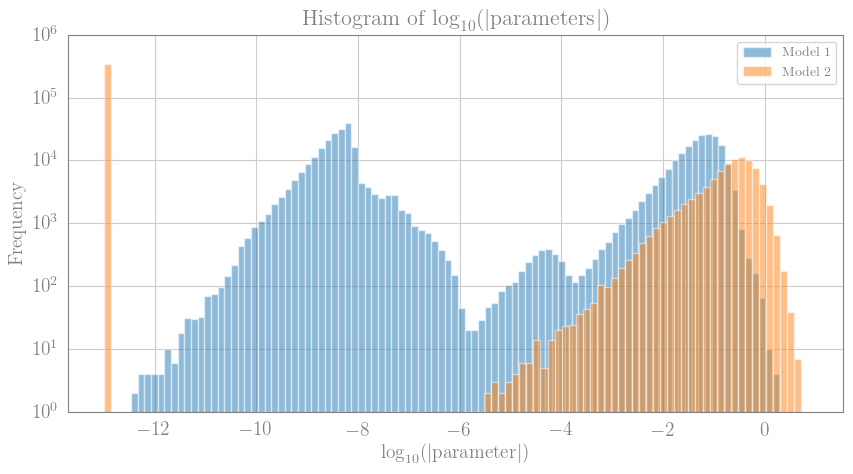

In [55]:
def get_parameters_log10(model):
    # Extract parameters and compute log10(abs(param))
    params = [p.data.view(-1).cpu().numpy() for p in model.parameters() if p.requires_grad]
    params = np.concatenate(params)  # Flatten the parameters
    return np.log10(np.abs(params) + 1e-13)  # Add a small constant to avoid log10(0)

# Get the log10(abs(parameters)) for each model
log_params_1 = get_parameters_log10(Model_1)
log_params_2 = get_parameters_log10(Model_2)

# Plot histograms
plt.figure(figsize=(10, 5))
plt.hist(log_params_1, bins=100, alpha=0.5, label='Model 1')
plt.hist(log_params_2, bins=100, alpha=0.5, label='Model 2')
plt.xlabel('$\log_{10}(|\mathrm{parameter}|)$', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Histogram of $\log_{10}(|\mathrm{parameters}|)$', fontsize=16)
plt.legend()
plt.grid(True)
plt.yscale('log')
plt.ylim(1,1e6)
plt.show()

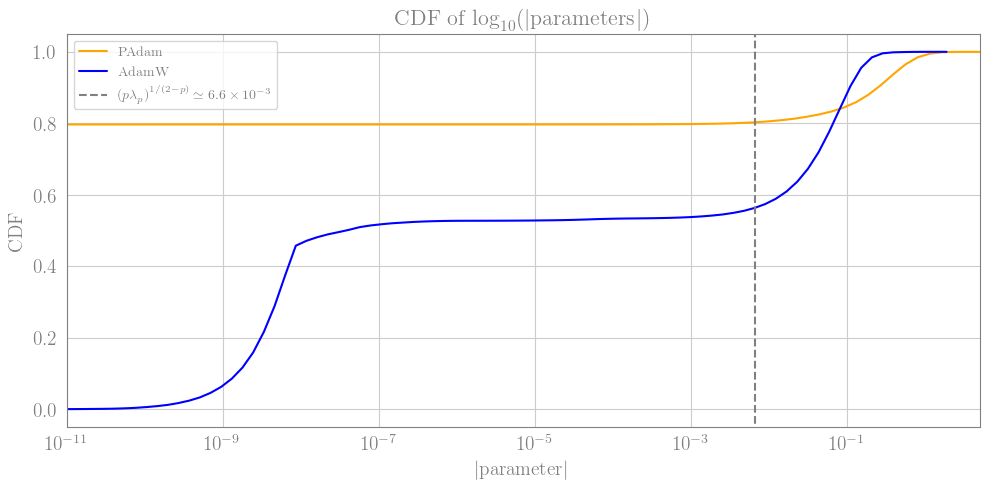

In [85]:
import matplotlib.pyplot as plt
import numpy as np

def get_parameters_log10(model):
    # Extract parameters and compute log10(abs(param))
    params = [p.data.view(-1).cpu().numpy() for p in model.parameters() if p.requires_grad]
    params = np.concatenate(params)  # Flatten the parameters
    return np.log10(np.abs(params) + 1e-15)  # Add a small constant to avoid log10(0)

# Get the log10(abs(parameters)) for each model
log_params_1 = get_parameters_log10(Model_1)
log_params_2 = get_parameters_log10(Model_2)

# Function to calculate CDF
def calculate_cdf(data, bins=100):
    count, bin_edges = np.histogram(data, bins=bins)
    cdf = np.cumsum(count)
    return bin_edges[1:], cdf / cdf[-1]  # Normalize

# Calculate CDF for each model
bins_edges_1, cdf_1 = calculate_cdf(log_params_1)
bins_edges_2, cdf_2 = calculate_cdf(log_params_2)

# Plot CDF
plt.figure(figsize=(10, 5))

plt.plot(10**bins_edges_2, cdf_2, label='PAdam',color='orange')
plt.plot(10**bins_edges_1, cdf_1, label='AdamW',color='blue')
plt.axvline((0.8*3e-3)**(1/(2-0.8)),-1,2,ls='--', color=text_and_line_color,label=r'$\left(p\lambda_p\right)^{1/(2-p)}\simeq6.6\times 10^{-3}$')
plt.xlabel('$|\mathrm{parameter}|$', fontsize=14)
plt.ylabel('CDF', fontsize=14)
plt.title('CDF of $\log_{10}(|\mathrm{parameters}|)$', fontsize=16)
plt.legend()
plt.xscale('log')
plt.xlim(1e-11,0.5e1)
plt.grid(True)


plt.tight_layout()
plt.savefig('../figs/fashion_padam_cdf', dpi=300, bbox_inches='tight', transparent=True)
plt.show()
